## CSCN8010 - Lab10
## Rohit Kumar 8895806
   

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand. 

This lab is the last one, so it is a bit more elaborated than the others. So make sure to take time to work through it.

A good starting point is to use the code in the notebook we went over in class - for fine-tuning VGG16. 

The goal of this lab is to achieve the best classification performance over three classes (species) of birds. This should be done by exploring data augmentation and fine-tuning of a pre-trained model (VGG16). Finally, explore and describe the results. 

If you are interested, you are encouraged to explore various training configurations, and see which one works better.

1. Obtain the Data
    1. Download the [BIRDS 525 SPECIES](https://www.kaggle.com/datasets/gpiosenka/100-bird-species?select=train) dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks. 
    2. Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (`ImageDataGenerator.flow_from_directory`). 
    3. For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

In [5]:
# Get dataset
# find 3 classes with the highest number of images

# use train data to find
train_folder = pathlib.Path('../data/birds/train')
test_folder = pathlib.Path('../data/birds/test')
valid_folder = pathlib.Path('../data/birds/valid')
train_folder

WindowsPath('../data/birds/train')

In [6]:

# dict to store image count for each class
image_count = {}

# Loop through sub directories and update the count for each class
for species in os.listdir(train_folder):
    species_path = os.path.join(train_folder, species)
    if os.path.isdir(species_path):
        image_count[species] = len(os.listdir(species_path))

# sort the dictionary to list 3 top class
top_3_class = sorted(image_count, key=image_count.get, reverse=True)[:3]

print('Top 3 class with highest number of images:', top_3_class)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '..\\data\\birds\\train'

In [3]:
# delete other directories for train folder
for species in os.listdir(train_folder):
    if species not in top_3_class:
        delete_path_train = os.path.join(train_folder, species)
        shutil.rmtree(delete_path_train)

# delete other directories for test folder
for species in os.listdir(test_folder):
    if species not in top_3_class:
        delete_path_test = os.path.join(test_folder, species)
        shutil.rmtree(delete_path_test)

# delete other directories for test folder
for species in os.listdir(valid_folder):
    if species not in top_3_class:
        delete_path_valid = os.path.join(valid_folder, species)
        shutil.rmtree(delete_path_valid)

2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [4]:
train_dataset = image_dataset_from_directory(
    train_folder,
    image_size=(224,224),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    valid_folder,
    image_size=(224,224),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    test_folder,
    image_size=(224,224),
    batch_size=32
)

Found 744 files belonging to 3 classes.


Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Found 744 images belonging to 3 classes.


Found 15 images belonging to 3 classes.


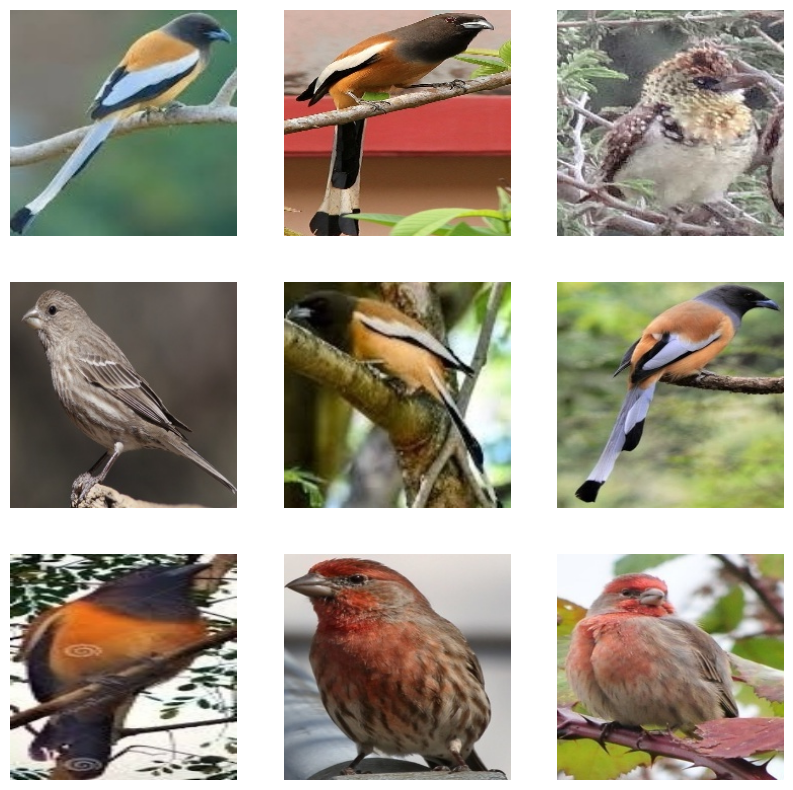

In [5]:
# use keras function of ImageDataGenerator.flow_from_directory

data_generator = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_generator.flow_from_directory(
    valid_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# display some augmented training images

# get images and labels from train_generator
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes (2 points)

In [6]:
# load pre-trained VGG16 model from imagenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a new dense layer
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# 3 classes
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# freeze all layers of pretrained model for fine-tuning
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [12]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 45s 2s/step - loss: 2.2561 - accuracy: 0.7863 - val_loss: 0.2519 - val_accuracy: 0.9333
Epoch 2/10
24/24 [==============================] - 47s 2s/step - loss: 0.3128 - accuracy: 0.9556 - val_loss: 7.6031e-05 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 51s 2s/step - loss: 0.2003 - accuracy: 0.9758 - val_loss: 5.1179e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 50s 2s/step - loss: 0.0660 - accuracy: 0.9906 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 49s 2s/step - loss: 0.1073 - accuracy: 0.9798 - val_loss: 6.9202e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 49s 2s/step - loss: 0.0715 - accuracy: 0.9852 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 49s 2s/step - loss: 0.1589 - accuracy: 0.9852 - val_loss: 1.1523e-06 - val_accuracy: 1.0000
Epoc

4. Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

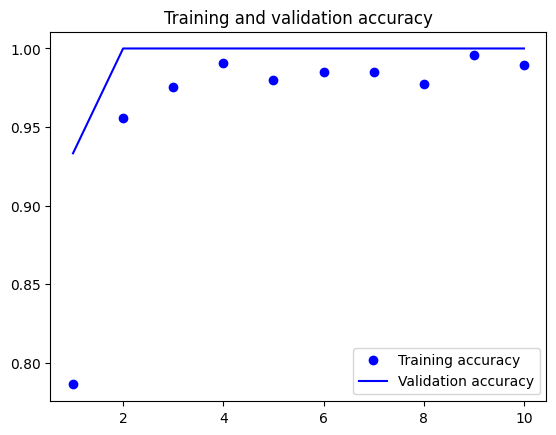

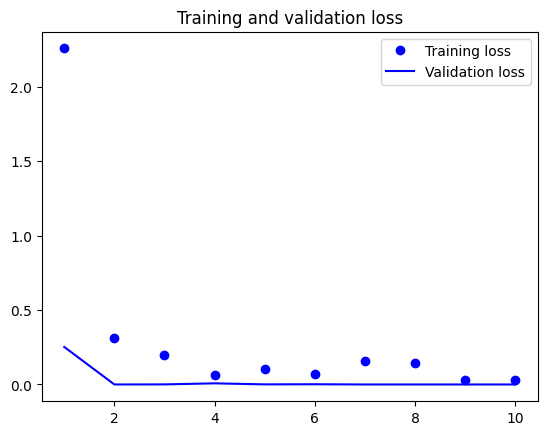

In [13]:
# Accuracy for training and validation
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 940ms/step - loss: 2.4410e-05 - accuracy: 1.0000
Test accuracy: 1.000


In [15]:
# Confusion matrix, Precision, Recall and F1-score
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall and F1-score
print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 1s 1s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.20      0.20      0.20         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.40      0.40      0.40         5

        accuracy                           0.27        15
       macro avg       0.27      0.27      0.27        15
    weighted avg       0.27      0.27      0.27        15



AUC for D-ARNAUDS BARBET: 0.2564185814185814
AUC for HOUSE FINCH: 0.3247202797202797
AUC for RUFOUS TREPE: 0.39992063492063495


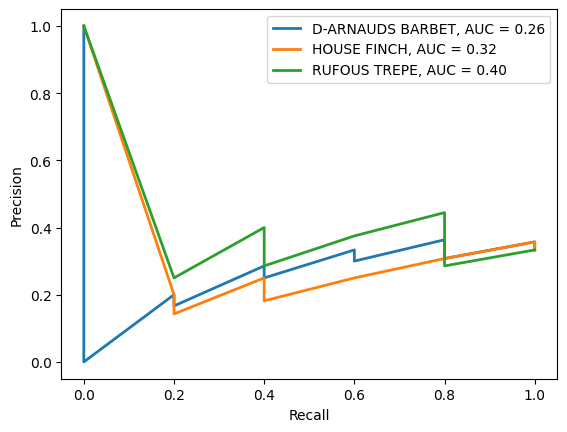

In [16]:
# convert true labels to one-hot encoding for multi-class
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

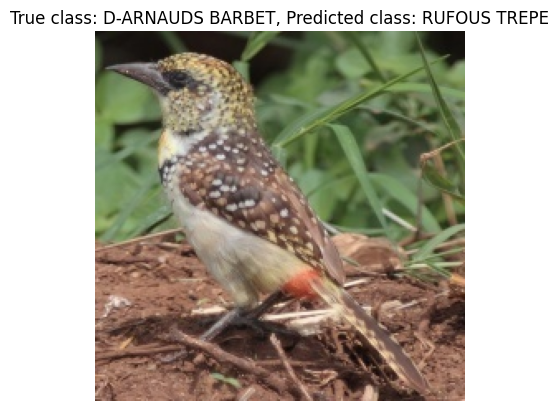

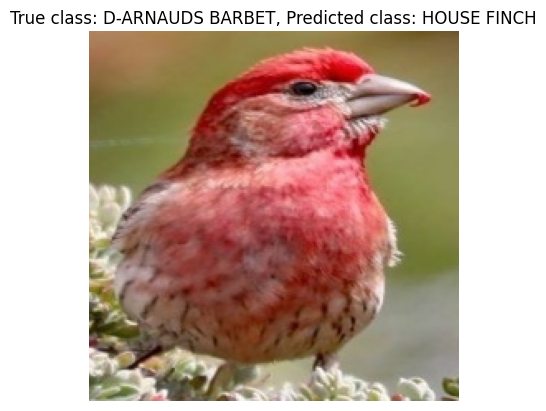

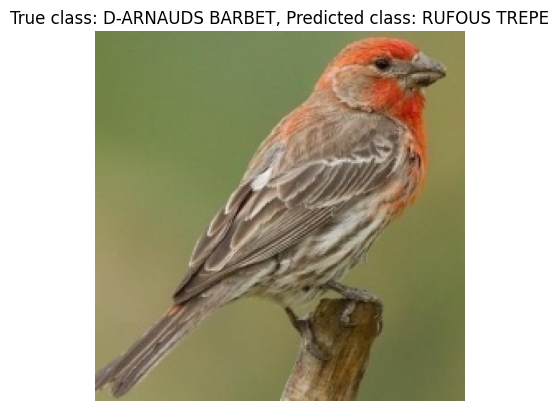

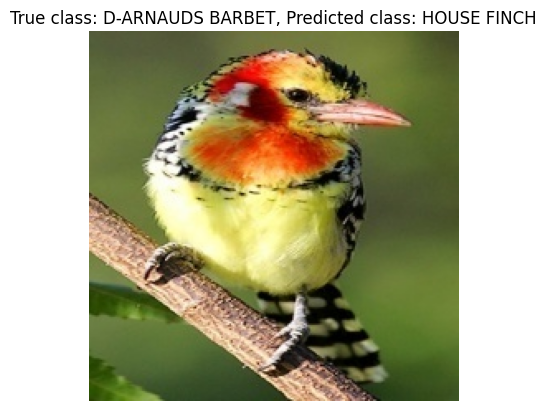

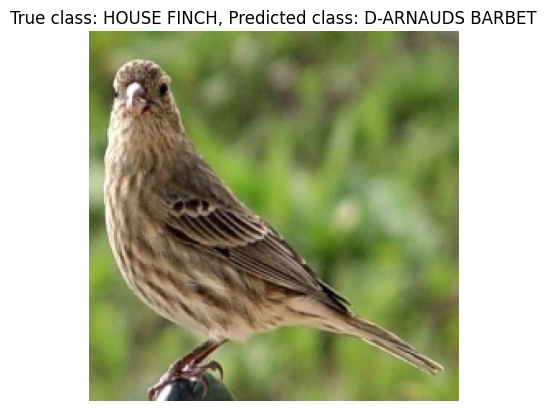

In [17]:
# explore incorrectly predicted examples
misclassfied_index = np.where(y_pred_class != y_true)[0]

# plot specific examples
for index in misclassfied_index[:5]:
    # get image from corresponding batch
    img_batch, _ = validation_generator[index // validation_generator.batch_size]
    img = img_batch[index % validation_generator.batch_size]
    
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_pred_class[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()